In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from tqdm import tqdm
# import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# import xgboost as xgb
# from sklearn import preprocessing, model_selection, pipeline
# from sklearn.metrics import f1_score, roc_auc_score
#
# from keras.models import Sequential
# from keras.layers import LSTM, GRU, Embedding, BatchNormalization
# from keras.layers.core import Dense, Activation, Dropout
# from keras.utils import np_utils
# from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
# from keras.preprocessing import sequence, text
# from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('../data/fake_job_postings.csv', engine = 'python')
df = df.drop(['job_id'], axis = 1)
# 대부분 missing 인 col 제거
df = df.drop(['department','salary_range'], axis = 1)
df.head()

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
# 우선 text 데이터 제외한 예측
df = df.drop(['title','company_profile','description','requirements','benefits'], axis = 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   location             17534 non-null  object
 1   telecommuting        17880 non-null  int64 
 2   has_company_logo     17880 non-null  int64 
 3   has_questions        17880 non-null  int64 
 4   employment_type      14409 non-null  object
 5   required_experience  10830 non-null  object
 6   required_education   9775 non-null   object
 7   industry             12977 non-null  object
 8   function             11425 non-null  object
 9   fraudulent           17880 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 1.4+ MB


In [5]:
df['fraudulent'].value_counts()

# 원래 fake job posting 비율
print('fake job posting 비율 : ', df['fraudulent'].value_counts()[1]/df.shape[0])

fake job posting 비율 :  0.04843400447427293


In [6]:
# 모든 missing을 단순히 제외하고 정상 데이터만 존재할 때 성능 확인해보자.
df_drop = df.dropna().reset_index(drop=True)

# location만 전처리 하고 (get_dummies에서 차원 너무 증가해)

# location 전처리
df_drop['location'] = df_drop['location'].apply(lambda x : str(x).split(',')[0])

# 10개 이상의 관측치 보유 location 만 남기기
loc_val_count = df_drop['location'].value_counts()
loc_over_10 = loc_val_count[loc_val_count>10].index
df_drop = df_drop[df_drop['location'].isin(loc_over_10)].reset_index(drop=True)


df_drop = pd.get_dummies(df_drop)
print("df_drop의 shape: ",df_drop.shape,"(location 전처리 전 1882 차원)")
print('fake job posting 비율 : ', df_drop['fraudulent'].value_counts()[1]/df_drop.shape[0])

df_drop의 shape:  (7397, 224) (location 전처리 전 1882 차원)
fake job posting 비율 :  0.04528863052588887


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

train =  df_drop.iloc[:-df.shape[0]//10,:]
test = df_drop.iloc[-df.shape[0]//10:,:]

x_train = train.drop(['fraudulent'],axis=1)
y_train = train['fraudulent']

x_test = test.drop(['fraudulent'],axis=1)
y_test = test['fraudulent']

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=2000,shuffle=True)

In [136]:
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
model = GradientBoostingClassifier()

grid=dict()
grid['n_estimators'] = [1000]
# grid['n_estimators'] = [10,50,100,500,1000,2000]
# grid['subsample'] = [0.5,0.7,1.0]
# grid['max_depth'] = [3,7,9]

#cv = RepeatedKFold(n_splits = 5, n_repeats= 1, random_state = 1)

grid_search = GridSearchCV(estimator = model,param_grid = grid,cv=5)

grid_result = grid_search.fit(x_train,y_train)

best_params= grid_result.cv_results_['params'][-1]

In [137]:
best_model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'])
from sklearn.ensemble import GradientBoostingRegressor
#best_regressor = GradientBoostingRegressor(n_estimators=2000)

best_model.fit(x_train,y_train)

GradientBoostingClassifier(n_estimators=1000)

In [138]:
from sklearn.metrics import classification_report

val_pred = best_model.predict(x_val)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1077
           1       0.89      0.56      0.68        45

    accuracy                           0.98      1122
   macro avg       0.94      0.78      0.84      1122
weighted avg       0.98      0.98      0.98      1122



In [8]:
# 전처리 후 성능 내기
df.isnull().sum()

location                346
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [9]:
# location 전처리

print('location null의 fake job posting 비율 : ', df[df['location'].isnull() ==True]['fraudulent'].value_counts()[1]/df[df['location'].isnull() ==True].shape[0])

# 국가명만 남기기
df['location'] = df['location'].apply(lambda x : str(x).split(',')[0])

# mode로 대체
df[df['location'].isnull() ==True]['location'] = df['location'].mode()[0]
# 10개 이상의 관측치 보유 location 만 남기기
loc_val_count = df['location'].value_counts()
loc_over_10 = loc_val_count[loc_val_count>10].index
df = df[df['location'].isin(loc_over_10)].reset_index(drop=True)

print("비율 차이 적으므로 mode로 imputation")


location null의 fake job posting 비율 :  0.05491329479768786
비율 차이 적으므로 mode로 imputation


required_experience 의 unique col 개수(nan포함) : 8
required_experience 의 missing 개수 : 6985
required_experience
Mid-Senior level    3772
Entry level         2674
Associate           2278
Not Applicable      1096
Director             385
Internship           380
Executive            140
Name: count, dtype: int64


<Axes: xlabel='required_experience', ylabel='fraudulent'>

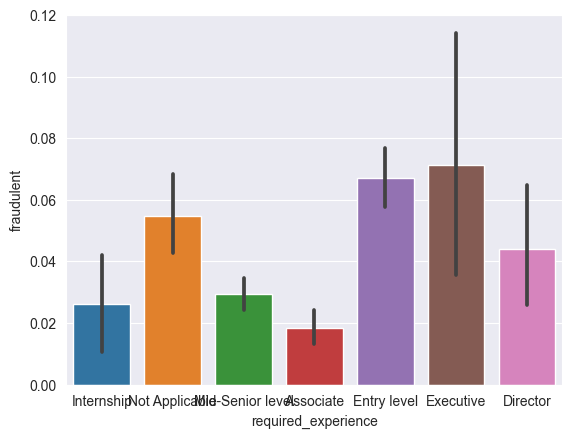

In [10]:
# required_experience 전처리
print('required_experience 의 unique col 개수(nan포함) :',len(df['required_experience'].unique()))
print('required_experience 의 missing 개수 :',df['required_experience'].isnull().sum())
print(df['required_experience'].value_counts())
sns.barplot(data=df, x='required_experience',y='fraudulent')

In [3]:
!pip install datawig
import datawig

input_columns = list(set(df.columns) - set(['required_experience']))
imputer = datawig.SimpleImputer(input_columns=input_columns,
                                output_column='required_experience')



  Using cached datawig-0.2.0.tar.gz (61 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached scikit-learn-0.22.1.tar.gz (6.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached typing-3.6.6-py3-none-any.whl (25 kB)
  Using cached pandas-0.25.3.tar.gz (12.6 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mxnet-1.4.0-py2.py3-none-win_amd64.whl (21.9 MB)
  Using cached numpy-1.14.6.zip (4.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached requests-2.18.4-py2.py3-none-any.whl (88 kB)
  Using cached idna-2.6-py2.py3-none-any.whl (56 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Us

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [137 lines of output]
  setup.py:461: UserWarning: Unrecognized setuptools command ('dist_info --egg-base C:\Users\user\AppData\Local\Temp\pip-modern-metadata-buut1szz'), proceeding with generating Cython sources and expanding templates
    warnings.warn("Unrecognized setuptools command ('{}'), proceeding with "
  setup.py:563: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
    from numpy.distutils.core import setup
  Running from SciPy source directory.
  INFO: lapack_opt_info:
  INFO: lapack_armpl_info

ModuleNotFoundError: No module named 'datawig'

In [ ]:
imputer.fit(train_df=df, num_epochs=50)
null_train = train[train['결측치를 포함하는 변수명'].isnull()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

required_education 의 unique col 개수(nan포함) : 14
required_education 의 missing 개수 : 8027
required_education
Bachelor's Degree                    5088
High School or equivalent            2075
Unspecified                          1386
Master's Degree                       405
Associate Degree                      274
Certification                         170
Some College Coursework Completed     100
Professional                           71
Vocational                             49
Doctorate                              26
Some High School Coursework            25
Vocational - HS Diploma                 8
Vocational - Degree                     6
Name: count, dtype: int64


<Axes: xlabel='required_education', ylabel='fraudulent'>

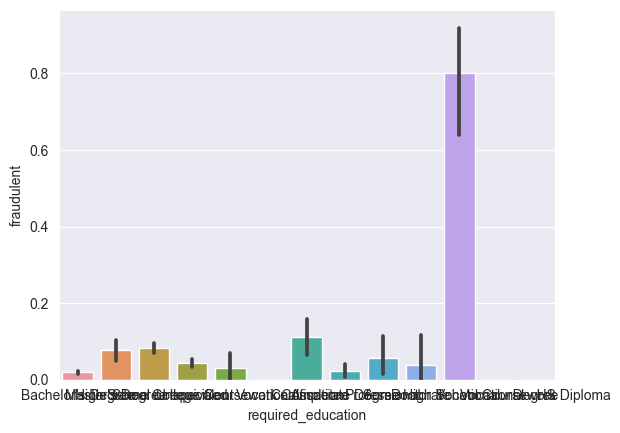

In [176]:
# required_education 전처리
print('required_education 의 unique col 개수(nan포함) :',len(df['required_education'].unique()))
print('required_education 의 missing 개수 :',df['required_education'].isnull().sum())
print(df['required_education'].value_counts())
sns.barplot(data=df, x='required_education',y='fraudulent')

In [206]:
# 같은 내용은 같은 카테고리로 분류
# 학사,고등,unspecified,ms,asoociate(준학사),certification은 자격증인데 따로두겠음,박사(profession).
# na->unspecified
# college 코스 completed -> 학사
# vocational -> 최소 고졸도 포함이므로 고졸
# doctorate -> 박사
# high school course -> 고졸
# hs diploma-> 고졸
# degree -> 대졸

# 아래 코드 왜 안되는지 모르겠네 후..
# df[df['required_education'].isna() ==True ]['required_education'] = "Unspecified"
#
# df[df['required_education']=='Some High School Coursework']['required_education'] = 'High School or equivalent'
# df[df['required_education']=='Vocational - HS Diploma']['required_education'] = 'High School or equivalent'
# df[df['required_education']=='Vocational']['required_education'] = "High School or equivalent"
#
# df[df['required_education']=='Some College Coursework Completed']['required_education'] = "Bachelor's Degree"
#
# df[df['required_education']=='Doctorate']['required_education'] = "Professional"

required_education 의 unique col 개수(nan포함) : 7
required_education 의 missing 개수 : 0
required_education
Unspecified                  9413
Bachelor's Degree            5188
High School or equivalent    2163
Master's Degree               405
Associate Degree              274
Certification                 170
Professional                   97
Name: count, dtype: int64


<Axes: xlabel='required_education', ylabel='fraudulent'>

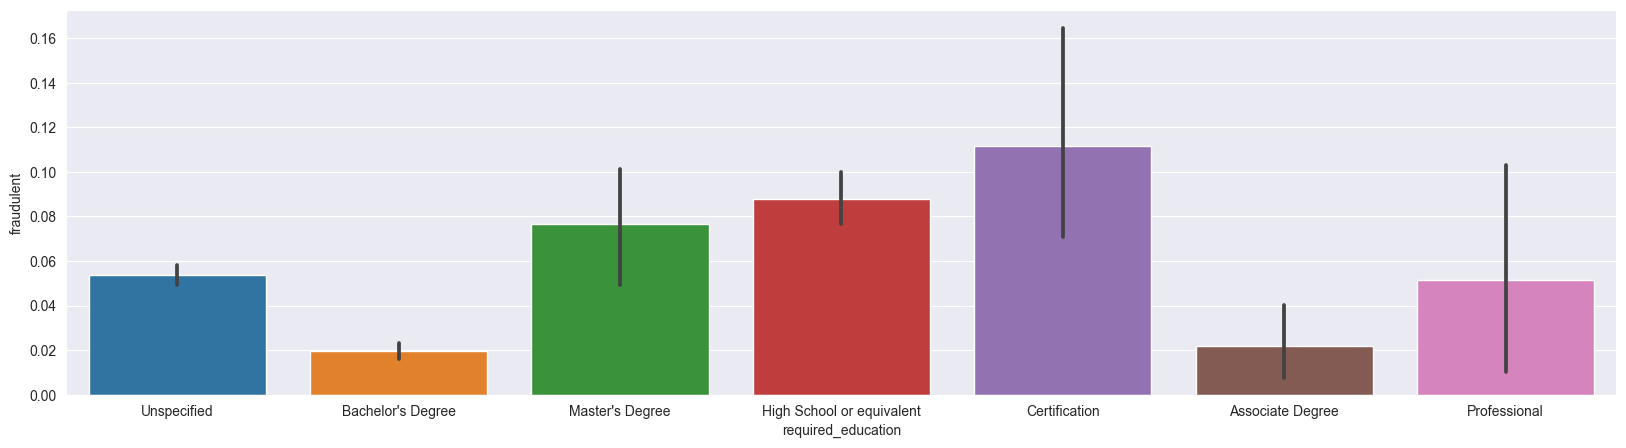

In [251]:
def replace_edu(rowdata):
    name = rowdata['required_education']

    if name == 'Some High School Coursework':
        return 'High School or equivalent'
    elif name == 'Vocational - HS Diploma':
        return 'High School or equivalent'
    elif name == 'Vocational - Degree':
        return 'High School or equivalent'
    elif name == 'Vocational':
        return 'High School or equivalent'
    elif name == 'Some College Coursework Completed':
        return "Bachelor's Degree"
    elif name == 'Doctorate':
        return "Professional"
    elif str(name) == 'nan':
        return "Unspecified"
    else:
        return name

df['required_education'] = df.apply(replace_edu, axis=1)
print('required_education 의 unique col 개수(nan포함) :',len(df['required_education'].unique()))
print('required_education 의 missing 개수 :',df['required_education'].isnull().sum())
print(df['required_education'].value_counts())
fig , ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(data=df, x='required_education',y='fraudulent')

employment_type
Full-time    11503
Contract      1516
Part-time      795
Temporary      240
Other          226
Name: count, dtype: int64
employment_type 의 missing 개수 : 3430


<Axes: xlabel='employment_type', ylabel='fraudulent'>

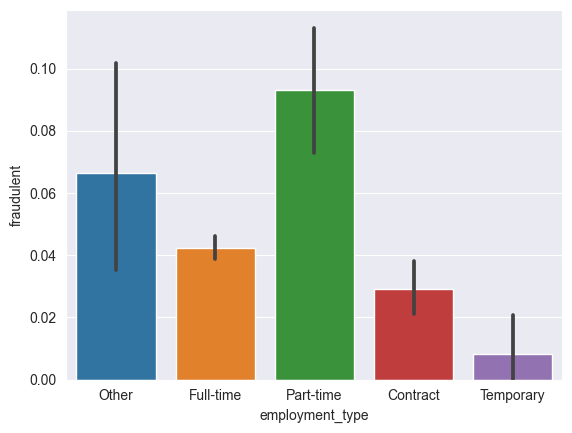

In [247]:
# employment_type 전처리

print(df['employment_type'].value_counts())
print('employment_type 의 missing 개수 :',df['employment_type'].isnull().sum())
df['employment_type'].value_counts()
sns.barplot(data=df, x='employment_type',y='fraudulent')

In [253]:
# industry 전처리

print(df['industry'].value_counts())
print('industry 의 missing 개수 :',df['industry'].isnull().sum())
df['industry'].value_counts()
# sns.barplot(data=df, x='industry',y='fraudulent')

industry
Information Technology and Services    1698
Computer Software                      1368
Internet                               1058
Marketing and Advertising               823
Education Management                    813
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: count, Length: 131, dtype: int64
industry 의 missing 개수 : 4856


industry
Information Technology and Services    1698
Computer Software                      1368
Internet                               1058
Marketing and Advertising               823
Education Management                    813
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: count, Length: 131, dtype: int64

In [254]:
# function 전처리 ( 필요시 nan이면 title에서 추출해오면 될 것 같기도 하고)

print(df['function'].value_counts())
print('function 의 missing 개수 :',df['function'].isnull().sum())
df['function'].value_counts()
# sns.barplot(data=df, x='function',y='fraudulent')

function
Information Technology    1730
Sales                     1455
Engineering               1334
Customer Service          1222
Marketing                  823
Administrative             627
Health Care Provider       337
Design                     336
Other                      322
Education                  316
Management                 311
Business Development       220
Accounting/Auditing        206
Human Resources            204
Project Management         183
Finance                    170
Consulting                 143
Writing/Editing            131
Art/Creative               131
Production                 116
Product Management         112
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                80
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    37

function
Information Technology    1730
Sales                     1455
Engineering               1334
Customer Service          1222
Marketing                  823
Administrative             627
Health Care Provider       337
Design                     336
Other                      322
Education                  316
Management                 311
Business Development       220
Accounting/Auditing        206
Human Resources            204
Project Management         183
Finance                    170
Consulting                 143
Writing/Editing            131
Art/Creative               131
Production                 116
Product Management         112
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                80
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    37

has_company_logo
1    14220
0     3660
Name: count, dtype: int64
company_logo 의 missing 개수 : 0


<Axes: xlabel='has_company_logo', ylabel='fraudulent'>

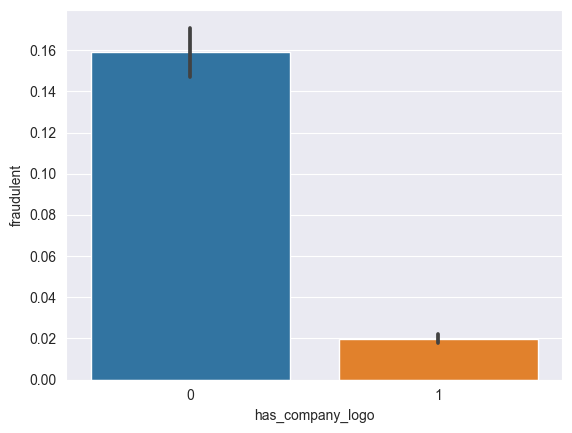

In [76]:
# has_company_logo 영향 유무

print(df['has_company_logo'].value_counts())
print('company_logo 의 missing 개수 :',df['has_company_logo'].isnull().sum())
sns.barplot(data=df, x='has_company_logo',y='fraudulent')